### Load the required libraries

In [20]:
%reload_ext autoreload
%autoreload 2

from PIL import Image
import cv2
from scipy import ndimage
import pandas as pd
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import random
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline


### vgg has features (contains convolutional layers) and classfier part (contains linear layers), we only need the features part

In [27]:
vgg = models.vgg19(pretrained=True)

In [28]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

### Since we are only going to optimize for the target image not not the network, we freeze all the layers

In [29]:
vgg = vgg.features
for param in vgg.parameters():
    param.requires_grad_(False)

### Check for GPU

In [30]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [31]:
if train_on_gpu:
    vgg = vgg.cuda()

### Identifying the layers and nomenclature
* We essentially need 'conv1_1', 'conv2_1', 'conv3_1',  'conv4_1','conv5_1' for style transfer and 'conv4_2' for content representation.
* conv1 or conv2 means the first and second block before a MaxPool
* conv1_1 is the first convolution in the first block

Check the representation in : https://cdn-images-1.medium.com/max/1600/1*FWxPihbEpjvAv7ITM9ljyg.png

In [20]:
[i for i,layer in enumerate(list(vgg.children())) if isinstance(layer,nn.Conv2d)]

[0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]

### Prepare Content and Style images

In [86]:
im1 = 'DB_photo1.jpg'
im2 = 'DB_photo2.jpg'
s_img = 'style2.jpg'

In [87]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

(1365, 2048, 3)

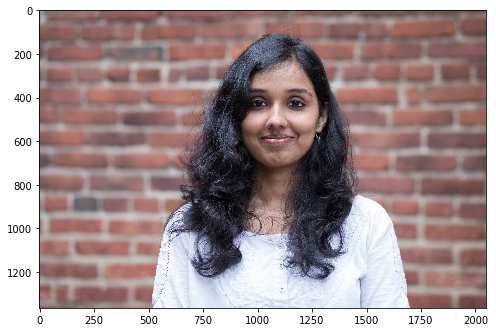

In [88]:
im1 = read_image(im1)
fig2 = plt.figure(figsize = (8,8)) 
plt.imshow(im1)
im1.shape

(812, 1022, 3)

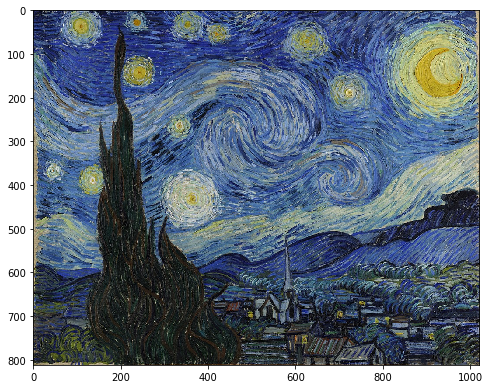

In [89]:
im2 = read_image(s_img)
fig2 = plt.figure(figsize = (8,8)) 
plt.imshow(im2)
im2.shape

In [90]:
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

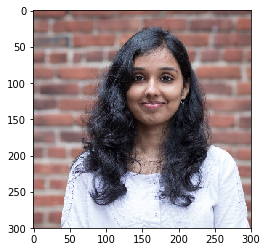

In [91]:
im1 = center_crop(im1)
im1 = cv2.resize(im1, (300, 300))
im1.shape
plt.imshow(im1)

(300, 300, 3)

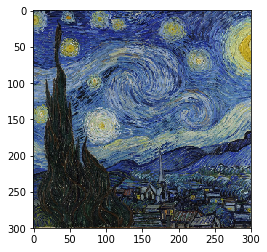

In [92]:
im2 = center_crop(im2)
im2 = cv2.resize(im2, (300, 300))
plt.imshow(im2)
im2.shape


In [93]:
def transform_images(im):
    """ Transform images to be ready for vgg"""
    im = np.rollaxis(im, 2)
    im = im[None]
    return torch.tensor(im, dtype=torch.float32).cuda()

In [94]:
np.rollaxis(im1,2)[None].shape

(1, 3, 300, 300)

In [95]:
im_style = transform_images(im2/255)
im_content = transform_images(im1/255)

### Target Image

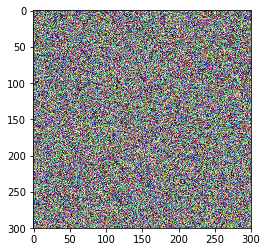

In [96]:
# start with a random image
opt_img = np.random.uniform(0, 1, size=im1.shape).astype(np.float32)
plt.imshow(opt_img)


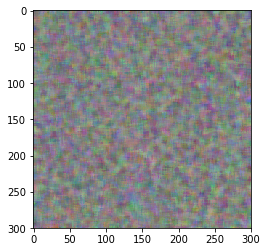

In [97]:
opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
opt_img = opt_img 
plt.imshow(opt_img)

In [98]:
im_opt = transform_images(opt_img)
im_opt.shape

torch.Size([1, 3, 300, 300])

In [99]:
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
im_opt.requires_grad=True

In [100]:
# Making the image pixes the parameters of the model
optimizer = optim.LBFGS([im_opt], lr=0.01)

In [56]:
layers = list(vgg.children())

#m_vgg = nn.Sequential(*layers[:19]) # after conv4_1
m_vgg = nn.Sequential(*layers[:10]) # after conv3_1
# freezing parameters
for param in m_vgg.parameters():
    param.requires_grad = False

In [57]:
# the target here is the output of the content image after passing through vgg19
targ_v = m_vgg(im_content).detach()
targ_v.shape

torch.Size([1, 128, 75, 75])

In [58]:
# for optim.LBFGS we have to define a closure function
def train_image(optimizer, targ_v, im_opt, iters):
    for i in range(iters):
        def closure():
            # constrain image to be between (0,1)
            im_opt.data.clamp_(0, 1)
            optimizer.zero_grad()
            loss = F.mse_loss(m_vgg(im_opt), targ_v)
            loss.backward()
            return loss
        optimizer.step(closure)
        if i%50 == 1:
            print(i, (F.mse_loss(m_vgg(im_opt), targ_v)).item())
    im_opt.data.clamp_(0, 1)
    return im_opt

In [59]:
im_opt = train_image(optimizer, targ_v, im_opt, 1000)

1 1.153605580329895
51 0.14429761469364166
101 0.09815409034490585
151 0.09301020205020905
201 0.08775261789560318
251 0.06570342928171158
301 0.061889149248600006
351 0.0605291947722435
401 0.0598619244992733
451 0.05267614871263504
501 0.0514211542904377
551 0.05079994723200798
601 0.050496093928813934
651 0.04633457586169243
701 0.04492999240756035
751 0.04450998827815056
801 0.0441688671708107
851 0.042663995176553726
901 0.040883541107177734
951 0.04070809483528137


In [60]:
x = im_opt.cpu().detach().numpy()
x = x[0]
x.shape

(3, 300, 300)

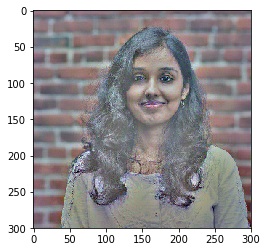

In [61]:
x = np.rollaxis(x,0,3)
plt.imshow(x)

In [189]:
vgg._modules.items()

odict_items([('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('1', ReLU(inplace)), ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('3', ReLU(inplace)), ('4', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('6', ReLU(inplace)), ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('8', ReLU(inplace)), ('9', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('11', ReLU(inplace)), ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('13', ReLU(inplace)), ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('15', ReLU(inplace)), ('16', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('17', ReLU(inplace)), ('18', MaxPool2d(kernel_size=2, str

### Get the features for content and style image

In [101]:
def get_input(lr=0.01, alpha=0.1):
    opt_img = np.random.uniform(0, 1, size=im1.shape).astype(np.float32)
    opt_img = ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img = (1-alpha)*opt_img + alpha*im2/255
    im_opt = transform_images(opt_img)
    im_opt.requires_grad=True
    optimizer = optim.LBFGS([im_opt], lr=0.01)
    return im_opt, optimizer
im_opt, optimizer = get_input()

In [102]:
class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(VGGNet, self).__init__()
        #self.select = ['0', '5', '10', '19', '28'] 
        self.select = ['0', '5', '10', '19'] 
        self.vgg = models.vgg19(pretrained=True).features
        for param in self.vgg.parameters():
            param.requires_grad = False
        
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

### Generate gram_matrix
<img src="gramMatrix.png">

In [103]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # unrolling feature maps

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [104]:
opt_img, optimizer = get_input(lr=0.1, alpha=0.0)
vgg = VGGNet().cuda().eval()
im_style_f = vgg(im_style)
[o.shape for o in im_style_f]

[torch.Size([1, 64, 300, 300]),
 torch.Size([1, 128, 150, 150]),
 torch.Size([1, 256, 75, 75]),
 torch.Size([1, 512, 37, 37])]

In [105]:
# note that gram_matrix(f) is location independent
targ_g = [gram_matrix(f).detach() for f in im_style_f]
[o.shape for o in targ_g]

[torch.Size([64, 64]),
 torch.Size([128, 128]),
 torch.Size([256, 256]),
 torch.Size([512, 512])]

In [106]:
def train_style(optimizer, targ_g, im_opt, iters):
    for i in range(iters):
        def closure():
            # constrain image to be between (0,1)
            im_opt.data.clamp_(0, 1)
            optimizer.zero_grad()
            # run the model
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*10000
            loss.backward()
            return loss
        optimizer.step(closure)
        if i%100 == 1:
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*10000
            print(i, loss.item())
    im_opt.data.clamp_(0, 1)
    return im_opt

1 0.12766167521476746
101 0.005041162017732859
201 0.003356941044330597
301 0.0027076364494860172
401 0.002486606827005744
501 0.00224568834528327
601 0.0019254136132076383
701 0.0018920536385849118
801 0.0018920069560408592
901 0.001891984837129712


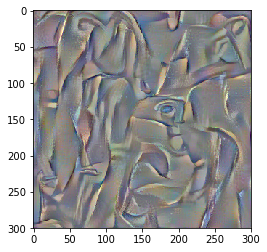

In [69]:
im_opt, optimizer = get_input(lr=0.1, alpha=0.0)
im_opt = train_style(optimizer, targ_g, im_opt, 1000)
x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
plt.imshow(x)

In [70]:
def train_style_transfer(optimizer, targ_g, targ_v, im_opt, iters, alpha=1.5):
    for i in range(iters):
        def closure():
            # constrain image to be between (0,1)
            im_opt.data.clamp_(0, 1)
            optimizer.zero_grad()
            # run the model
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*1000*alpha
            loss += F.mse_loss(out[2], targ_v.detach())
            loss.backward()
            return loss
        optimizer.step(closure)
        if i%50 == 1:
            out = vgg(im_opt)
            input_g = [gram_matrix(f) for f in out]
            losses = [F.mse_loss(o, t) for o,t in zip(input_g, targ_g)]
            loss = sum(losses)*1000*alpha
            loss += F.mse_loss(out[2], targ_v.detach())
            print(loss.item())
    im_opt.data.clamp_(0, 1)
    return im_opt

In [107]:
im_style_f = vgg(im_style)
targ_g = [gram_matrix(f).detach() for f in im_style_f]
im_content_f = vgg(im_content)
targ_v = im_content_f[2].detach()
targ_v.shape

torch.Size([1, 256, 75, 75])

In [108]:
im_opt, optimizer = get_input(lr=0.5)
im_opt = train_style_transfer(optimizer, targ_g, targ_v, im_opt, 1000, alpha=500)

8.70446491241455
1.127487063407898
0.9695619344711304
0.9477264285087585
0.9398019909858704
0.9168573617935181
0.9046469926834106
0.9022693634033203
0.8842863440513611
0.879708468914032
0.8766379356384277
0.8684157729148865
0.8673804998397827
0.865558385848999
0.864710807800293
0.860413134098053
0.8528474569320679
0.8520258665084839
0.8515909910202026
0.8470727801322937


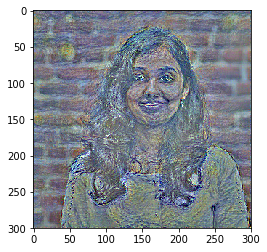

In [109]:
x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
plt.imshow(x)

14.843317031860352
1.2766646146774292
1.0733978748321533
1.043996810913086
1.0353174209594727
1.0267170667648315
1.016331434249878
1.0121639966964722
1.0055471658706665
0.9809913635253906
0.9774523973464966
0.9728900194168091
0.962928295135498
0.9615483283996582
0.9597694873809814
0.9543272256851196
0.9528821110725403
0.9521174430847168
0.9468544721603394
0.9433361291885376


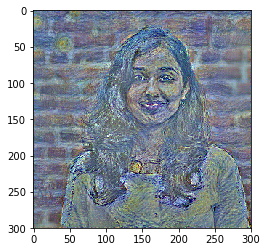

In [110]:
im_opt, optimizer = get_input(lr=0.5)
im_opt = train_style_transfer(optimizer, targ_g, targ_v, im_opt, 1000, alpha=900)
x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
plt.imshow(x)

In [ ]:
im_opt, optimizer = get_input(lr=0.5)
im_opt = train_style_transfer(optimizer, targ_g, targ_v, im_opt, 1000, alpha=1500)
x = im_opt.cpu().detach().numpy()
x = np.rollaxis(x[0],0,3)
plt.imshow(x)

### Layer weights
* Initial layers capture larger features and as we go deep network the filters capture much pronounced details
* We can alter the weights based on our need

Reference:
* https://medium.com/artists-and-machine-intelligence/neural-artistic-style-transfer-a-comprehensive-look-f54d8649c199
* https://github.com/yanneta/deep-learning-data-institute/blob/master/lesson7-style-trasfer.ipynb